In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, train_test_split
url_csv = 'https://raw.githubusercontent.com/CausalML/TreatmentEffectRisk/main/data/behaghel.csv'
import warnings
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

warnings.filterwarnings('ignore')

In [2]:
original_result = pd.read_csv("../data/results.csv")

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
import xgboost as xgb

# Cargar los datos
job = pd.read_csv(url_csv)

# Definir las variables categóricas (binarias) y numéricas
Xbin = [
    'College_education', 'nivetude2', 'Vocational', 'High_school_dropout', 
    'Manager', 'Technician', 'Skilled_clerical_worker', 'Unskilled_clerical_worker', 
    'Skilled_blue_colar', 'Unskilled_blue_colar', 'Woman', 'Married', 'French', 
    'African', 'Other_Nationality', 'Paris_region', 'North', 'Other_regions', 
    'Employment_component_level_1', 'Employment_component_level_2', 
    'Employment_component_missing', 'Economic_Layoff', 'Personnal_Layoff', 
    'End_of_Fixed_Term_Contract', 'End_of_Temporary_Work', 'Other_reasons_of_unemployment', 
    'Statistical_risk_level_2', 'Statistical_risk_level_3', 'Other_Statistical_risk', 
    'Search_for_a_full_time_position', 'Sensitive_suburban_area', 'Insertion', 
    'Interim', 'Conseil'
]

Xnum = [
    'age', 'Number_of_children', 'exper', 'salaire.num', 'mois_saisie_occ', 'ndem'
]

Xall = Xbin + Xnum

# Filtrar y transformar los datos
job_binary = job[(job['A_public'] == 1) | (job['A_private'] == 1)].copy()
job_binary['sw'] = job_binary['sw'] / job_binary['sw'].mean()
job_binary['A'] = job_binary['A_public']
job_binary['ipw'] = 1 / (
    job_binary['A_standard'] * job_binary['sw'] * job_binary['A_standard'].mean() + 
    job_binary['A_private'] * job_binary['sw'] * job_binary['A_private'].mean() + 
    job_binary['A_public'] * job_binary['sw'] * job_binary['A_public'].mean()
)


In [12]:
from utils import make_cvgroup_balanced
from models import tau_predict, mu_calculate, var_calculate
ps = np.arange(0.01, 1.01, 0.01)
bs = np.arange(0, 0.30, 0.05)
rhos = [-1, -0.5, 0, 0.5, 0.9, 0.95, 1]

In [4]:

np.random.seed(0)
K = 5
cvgroup = make_cvgroup_balanced(job_binary, K, 'A')


In [5]:

job_binary['y_ref'] = (2 * job_binary['A'] - 1) * job_binary['ipw'] * job_binary['Y']

# X and y for the model
X = job_binary[Xall]  # Assuming Xall is a list of column names
y = job_binary['y_ref']

tau_pred = tau_predict(X, y, job_binary['sw'])



In [6]:
bad_c = ['age','Paris_region','African','High_school_dropout']
Xbad = job_binary[bad_c]
tau_pred_bad = tau_predict(Xbad, y, job_binary['sw'])

In [7]:

y = job_binary['Y']
X = job_binary[Xall]
mu0, mu1 = mu_calculate(
    job_binary, cvgroup, y, X 
)

In [8]:
job_binary['mu0'] = mu0
job_binary['mu1'] = mu1
var0, var1 = var_calculate(job_binary, job_binary[Xall], cvgroup)
job_binary['var0'] = var0
job_binary['var1'] = var1
job_binary['tau'] = tau_pred
job_binary['tau_bad'] = tau_pred_bad

# Plots

In [10]:
from plots import plot_cvar_group, plot_cvar_groups_with_markers
from plots import plot_cvar, plot_CVAR_TE
from gen_cvar import cvar_tau, cvar_plugin, cvar_mate, cvar_bbound_mate, cvar_bbounded, prep_bbounds_ate, job_condvar_gen, cvar_bbounds_ate

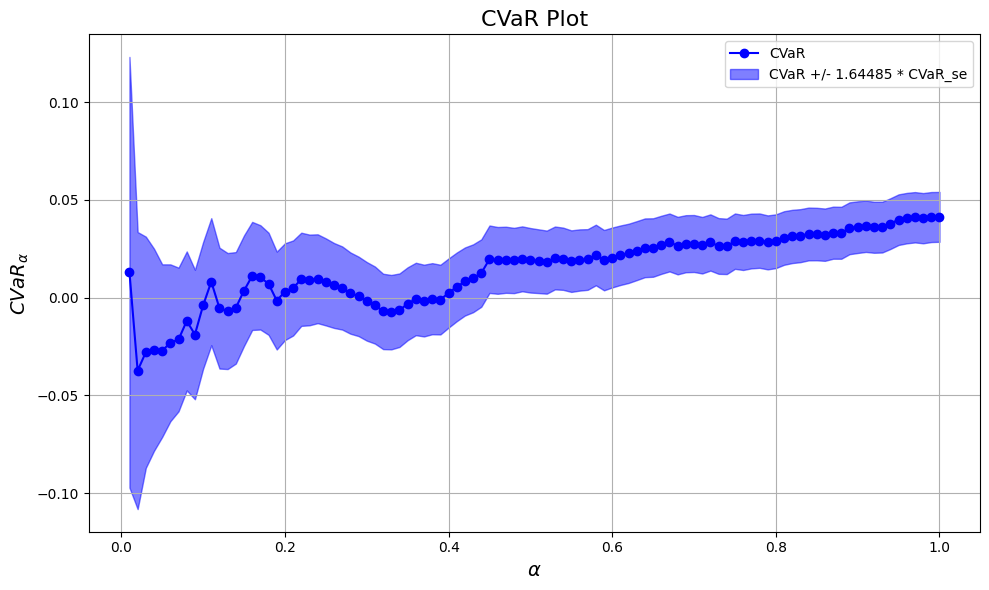

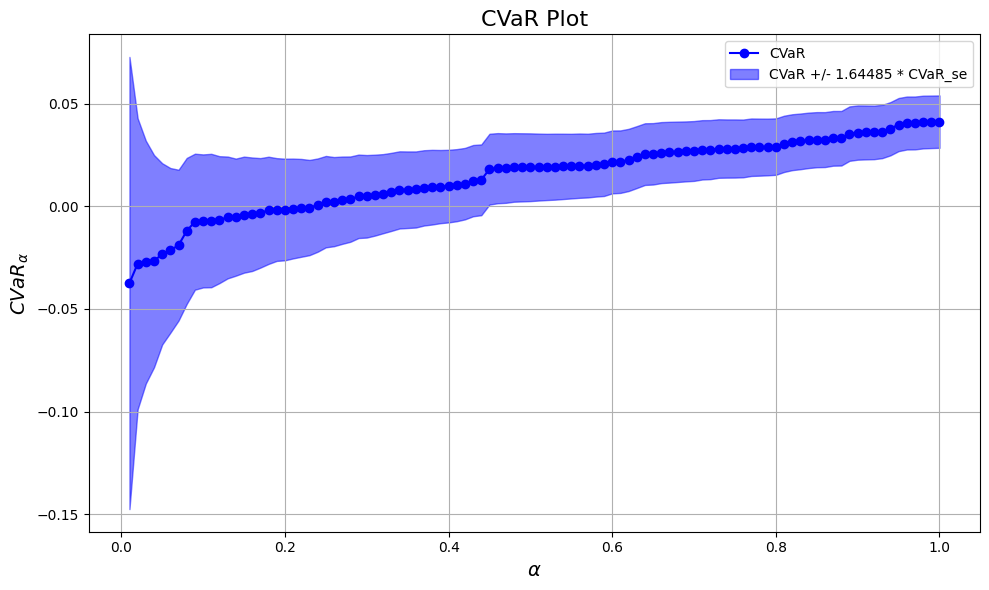

In [14]:
CVaR = cvar_tau(job_binary, ps)
plot_cvar(CVaR, rearrangement=False)
plot_cvar(CVaR, rearrangement=True)

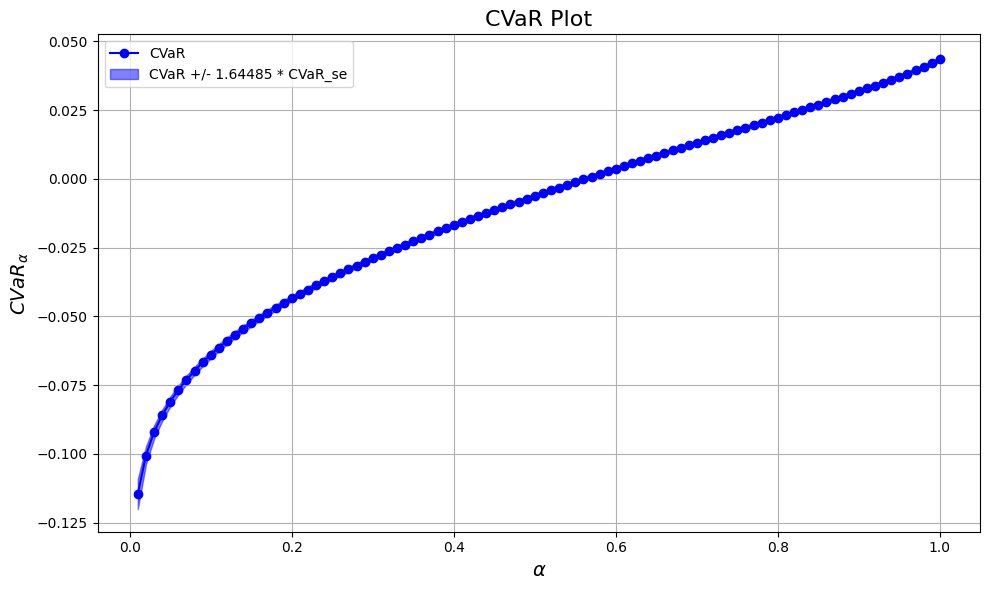

In [15]:
cvar_p = cvar_plugin(job_binary, ps)

plot_cvar(cvar_p)

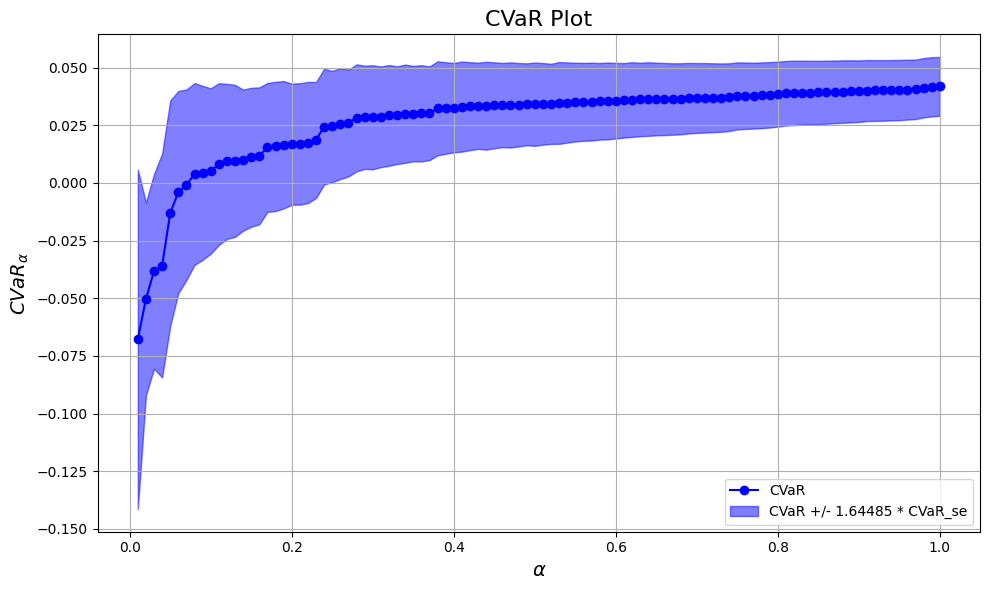

In [17]:
cvar_bad = cvar_tau(job_binary, ps, tau_col='tau_bad')
plot_cvar(cvar_bad, rearrangement=True)

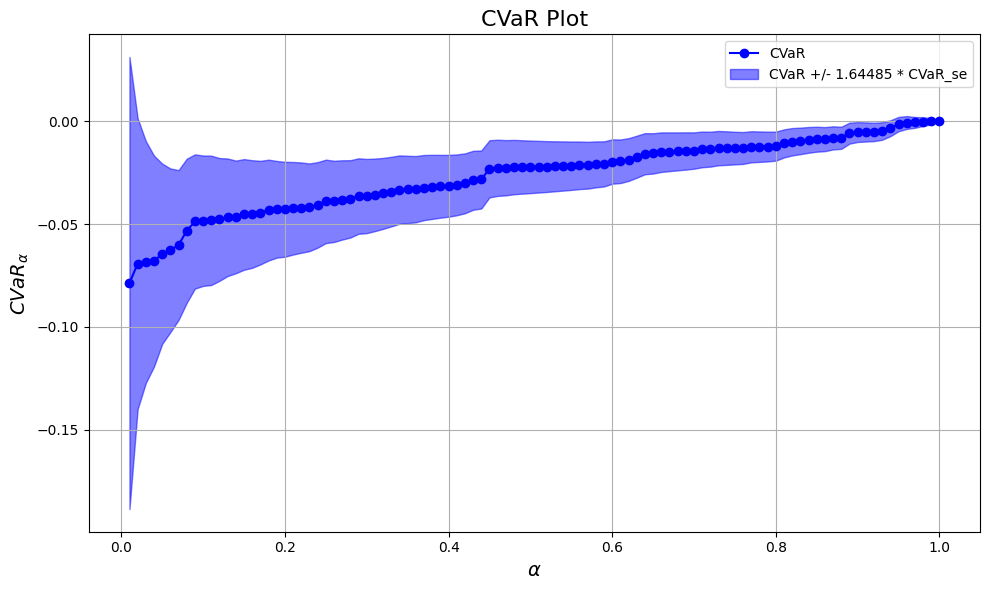

In [18]:
cvarmate = cvar_mate(job_binary, ps)
plot_cvar (cvarmate , rearrangement= True)

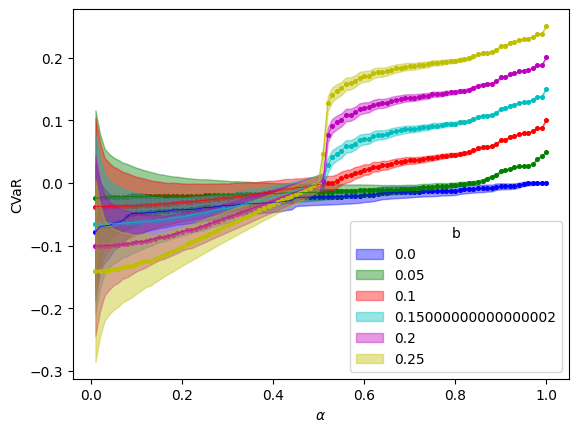

In [19]:
cvar_bbound_mate_df = cvar_bbound_mate(job_binary, ps, bs)
plot_cvar_group(cvar_bbound_mate_df)

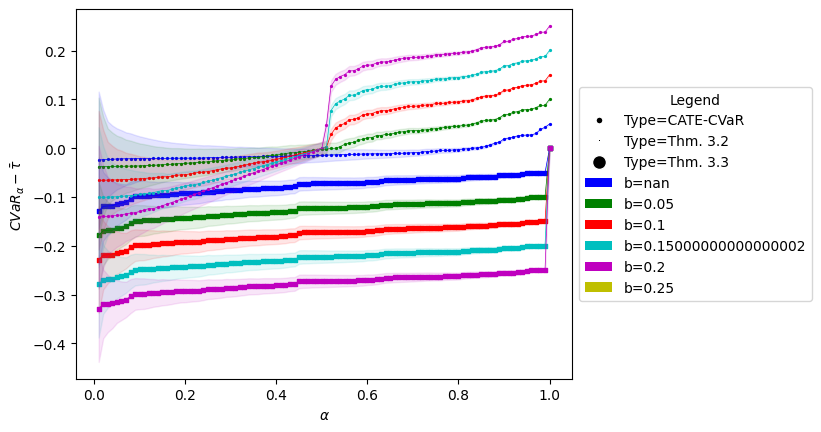

In [20]:
df_bounded = cvar_bbounded(cvarmate, cvar_bbound_mate_df, bs)
plot_cvar_groups_with_markers(
    df_bounded, "p", y = "CVaR"
)

In [21]:

d, t, c1, c2 = prep_bbounds_ate(job_binary)
sbound_mate = cvar_bbounds_ate (d, ps, rhos, t)

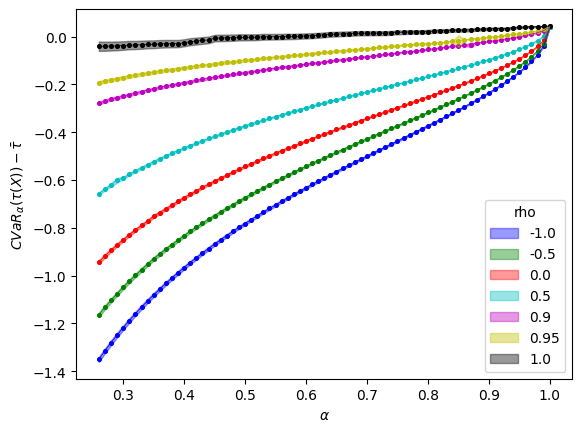

In [22]:
plot_cvar_group(
    sbound_mate.query("p>0.25"), group='rho', 
    y_label=r"${CVaR}_{\alpha}(\tau(X))-\bar\tau$"
)   

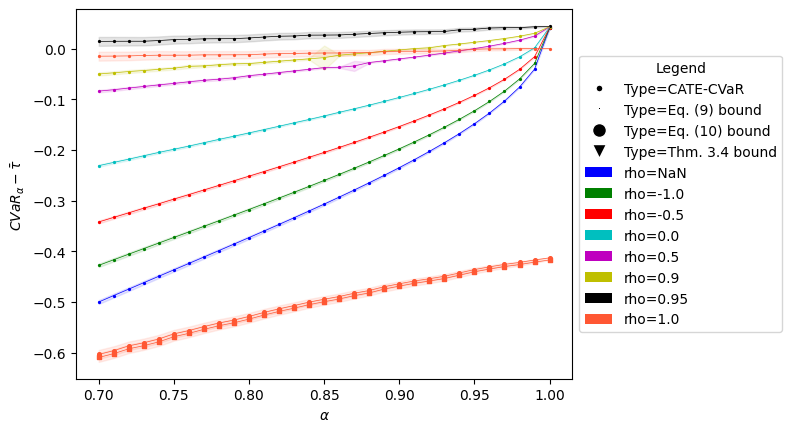

In [23]:
job_condvar = job_condvar_gen(cvarmate, sbound_mate, c1, c2)
plot_cvar_groups_with_markers(
    job_condvar,
    "p", "CVaR", main_group='rho', cvar_se="CVaR_se",
    y_label=r"${CVaR}_{\alpha}-\bar{\tau}$"
)

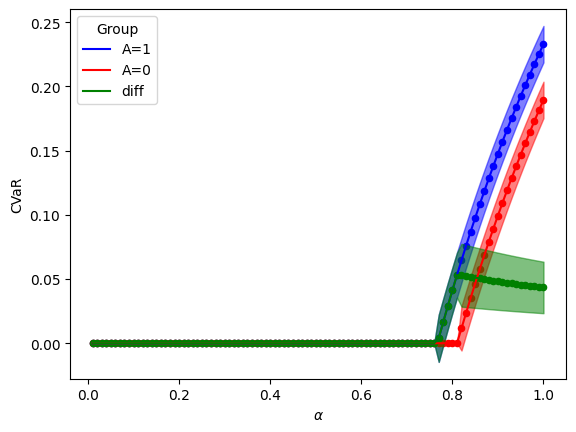

In [24]:
plot_CVAR_TE(job_binary, ps)